In [1]:
#default_exp evaluation

In [2]:
#export

import os
import pickle
import attr

import pandas as pd
import scipy
import numpy as np
from functools import partial


from game_recommender import steam_data, content_based, user_based, hybrid

In [3]:
%cd ..

/home/kuba/Projects/game_recommender


In [4]:
game_dataset = steam_data.get_steam_ratings_dataset()

In [5]:
user_based_recommender = user_based.UserBasedRecommender.make_from_steam_ratings('log_hours')
content_based_recommender = content_based.ContentBasedRecommender.make_from_steam_metadata()

In [6]:
#export


class metrics:
        
    @staticmethod
    def get_correlation(user_ratings, recommendations, method=scipy.stats.kendalltau):
        user_ratings_with_zeros, recommendations_with_zeros, n_compared = metrics._make_data_for_correlation_comparison(user_ratings, recommendations) 
        return method(user_ratings_with_zeros[:n_compared], recommendations_with_zeros[:n_compared])[0]

    @staticmethod
    def get_recall_at(user_ratings, recommendations, k=10):
        user_games = user_ratings.sort_values(ascending=False)[:k]
        recommended_games = recommendations.sort_values(ascending=False)[:k]
        return recommended_games.index.isin(user_games.index).sum() / len(user_games)

    @staticmethod
    def _fill_nonexistent_with_zeros(source, target):
        not_in_source = target[~target.index.isin(source.index)].index
        zeroed_not_in_source = pd.Series(index=not_in_source, data=np.zeros_like(not_in_source))
        return pd.concat([source, zeroed_not_in_source])

    @staticmethod
    def _make_data_for_correlation_comparison(user_ratings, recommendations):
        user_ratings_with_zeros = metrics._fill_nonexistent_with_zeros(recommendations, user_ratings)
        recommendations_with_zeros = metrics._fill_nonexistent_with_zeros(user_ratings, recommendations)[user_ratings_with_zeros.index]
        n_compared = min([len(user_ratings), len(recommendations)])
        return user_ratings_with_zeros, recommendations_with_zeros, n_compared


In [7]:
user_item_df = game_dataset.get_user_item_df()

# Evaluating recommendations for an example user

In [8]:
i = 10
user_id = user_based_recommender.user_similarity_searcher.df.iloc[i,0]
user_ratings_raw = user_item_df.iloc[i]
user_ratings = user_ratings_raw[~user_ratings_raw.isna()]

In [9]:
user_ratings

name
counter strike                     3.135494
counter strike global offensive    6.194405
counter strike nexon zombies       0.693147
counter strike source              0.693147
day of defeat                      0.693147
deathmatch classic                 0.693147
eldevin                            0.693147
half life                          0.693147
half life blue shift               0.693147
half life opposing force           0.693147
planetside 2                       0.693147
raceroom racing experience         0.336472
realm of the mad god               0.693147
ricochet                           0.693147
team fortress classic              0.693147
unturned                           0.693147
warface                            0.693147
Name: 547685, dtype: float64

In [10]:
recommender = hybrid.HybridRecommender(content_based_recommender, user_based_recommender)

recommendations = recommender.get_weighted_recommendations(user_ratings, 20, user_recommendation_weight=1, content_recommendation_weight=1, mean_content_recommendation_weight=1)

In [11]:
metrics.get_recall_at(user_ratings, recommendations)

0.3

In [12]:
metrics._fill_nonexistent_with_zeros(user_ratings, recommendations)

counter strike                      3.13549
counter strike global offensive     6.19441
counter strike nexon zombies       0.693147
counter strike source              0.693147
day of defeat                      0.693147
deathmatch classic                 0.693147
eldevin                            0.693147
half life                          0.693147
half life blue shift               0.693147
half life opposing force           0.693147
planetside 2                       0.693147
raceroom racing experience         0.336472
realm of the mad god               0.693147
ricochet                           0.693147
team fortress classic              0.693147
unturned                           0.693147
warface                            0.693147
call of duty 4 modern warfare             0
world of tanks blitz mmo                  0
tanki online                              0
blockade classic                          0
team fortress 2                           0
post scriptum                   

In [13]:
metrics.get_correlation(user_ratings, recommendations, method=scipy.stats.kendalltau)

0.10891622972743417

In [14]:
@attr.s
class HybridRecommenderEvaluator:
    
    recommender: hybrid.HybridRecommender = attr.ib()
        
    def get_per_user_recommendation_groups(self, users_ratings, n_recommended=20, n_similar_users=10, n_similar_items=10):
        return [recommender.get_recommendation_groups(user_ratings, n_similar_users, n_similar_items) for user_ratings in users_ratings]
    
    def get_metric_values(
            self,
            users_ratings,
            user_recommendations_groups,
            n_recommended,
            metric,
            user_recommendation_weight=1,
            content_recommendation_weight=1,
            mean_content_recommendation_weight=1
            ):
        
        weights = [user_recommendation_weight, content_recommendation_weight, mean_content_recommendation_weight]
        metric_values = [
            metric(users_ratings, recommender.weigh_recommendations(user_recommendation_group, weights, n_recommended))
            for users_ratings, user_recommendation_group in zip(user_ratings, user_recommendations_groups)
        ]
        return pd.Series(metric_values)

In [15]:
user_item_df_with_rankings = user_item_df[user_item_df.var(axis=1) > 1e-4]

In [16]:
users_ratings_raw = user_item_df_with_rankings.iloc[:500]
user_ratings = [ratings.dropna() for (__, ratings) in users_ratings_raw.iterrows()]

#user_ratings = user_ratings_raw[~user_ratings_raw.isna()]

In [17]:
(user_item_df.var(axis=1) < 1e-4).mean()

0.03046218487394958

In [18]:
evaluator = HybridRecommenderEvaluator(recommender)

In [19]:
%%time
rec_groups = evaluator.get_per_user_recommendation_groups(user_ratings)

CPU times: user 3min 45s, sys: 8.77 s, total: 3min 54s
Wall time: 3min 54s


count    500.000000
mean       0.503060
std        0.314806
min        0.000000
25%        0.300000
50%        0.500000
75%        0.714286
max        1.000000
dtype: float64

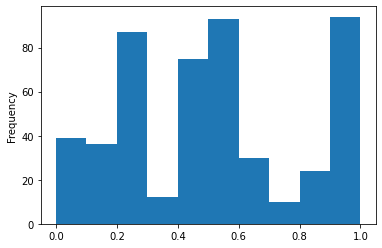

In [20]:
recall = evaluator.get_metric_values(rec_groups, rec_groups, 10, metrics.get_recall_at, 1, 1, 1)
recall.plot.hist()
recall.describe()

count    496.000000
mean       0.152909
std        0.304881
min       -0.800000
25%       -0.039722
50%        0.127173
75%        0.358613
max        0.856349
dtype: float64

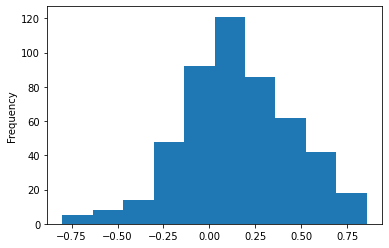

In [21]:
correlation = evaluator.get_metric_values(rec_groups, rec_groups, 20, partial(metrics.get_correlation, method=scipy.stats.kendalltau), 1, 1, 1)
correlation.plot.hist()
correlation.describe()

In [22]:
user_ratings[3]

name
counter strike              0.095310
day of defeat               0.693147
deathmatch classic          0.693147
half life                   0.693147
half life blue shift        0.693147
half life opposing force    0.693147
ricochet                    0.693147
team fortress classic       0.693147
Name: 144736, dtype: float64

In [23]:
??scipy.stats.kendalltau

In [24]:
example_user_ratings = user_ratings[-2]

In [25]:
example_user_ratings

name
age of chivalry                                0.693147
alien swarm                                    0.262364
brawlhalla                                     0.182322
contagion                                      0.641854
counter strike global offensive                1.386294
dino d day                                     0.693147
dungeon defenders 2                            0.095310
e.y.e divine cybermancy                        1.098612
floating point                                 0.095310
garrys mod                                     3.044522
gear up                                        0.693147
grand theft auto 4                             1.098612
grand theft auto episodes from liberty city    0.693147
gunpoint                                       0.693147
half life 2                                    0.693147
half life 2 deathmatch                         0.693147
half life 2 episode one                        0.693147
half life 2 episode two                    